<a href="https://colab.research.google.com/github/Andrey-Epifanov-k721/conv_networks/blob/master/object_detection_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png", width=500></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h1 style="text-align: center;"><b>Object detection</b></h1>

### Руководитель проекта:
* Юрий Яровиков (AIRI, МФТИ) | tg:@yu_rovikov

<h1 style="text-align: center;"><b>Треки на проекте</b></h1>
На этом проекте есть два возможных трека, из которых нужно выбрать один.

* **Первый трек --- исследовательский**. На этом треке вам предстоит самостоятельно обучить и протестировать предобученную модель детекции. Основной упор делается на моделирование и обучение. Необходимо будет попробовать несколько моделей детекции, самостоятельно реализовать метрики.

* **Второй трек --- продуктовый**. На этом треке вам не понадобится обучать свою модель детекции (хотя никто не запрещает вам это делать), но необходимо, во-первых, продумать **продуктовую составляющую проекта** (проблема людей, которая решается в данном проекте, целевая аудитория продукта, оптимальный способ внедрения модели), а также создать [MVP](https://ru.wikipedia.org/wiki/%D0%9C%D0%B8%D0%BD%D0%B8%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE_%D0%B6%D0%B8%D0%B7%D0%BD%D0%B5%D1%81%D0%BF%D0%BE%D1%81%D0%BE%D0%B1%D0%BD%D1%8B%D0%B9_%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%82) , **внедрив модель в цифровой сервис**, который может быть реализован как Telegram-бот, Web-демо, Desktop-приложение.

Вам необходимо выбрать основной сценарий, по которому вы пойдете, указав это при сдаче работы. При этом, никто не мешает вам совместить два трека, проведя и моделирование, и встраивание в демо. В этом случае мы рекомендуем пойти по **плану из второго трека**, а за моделирование будут ставиться бонусные баллы.

Обратите внимание, что суммарный балл по проекту не может превышать 10. Максимальный балл можно получить на любом из двух треков.

# Исследовательский трек
На этом треке вам предстоит самостоятельно обучить и протестировать предобученную модель детекции. Основной упор делается на моделирование и обучение. Необходимо попробовать несколько моделей детекции и провести их объективное сравнение в соответствии с целевой метрикой проекта.

## План работы




### 1. Выбор фреймворка/библиотеки для использования детектора (1 балл)

Чтобы освежить память о задаче детекции, можно посмотреть [занятия на продвинутом курсе](https://stepik.org/lesson/458312/step/1?unit=616130).

В выборе фреймворка предоставляется свобода, лично я рекомендовал бы один из:
- `torchvision.models.detection` и `torchhub`: "нативные" модели для детектирования прямо из PyTorch. Примеры использования есть прямо на занятиях DLSchool по практике CV [2019 года](https://www.youtube.com/watch?v=XSPYe4-y4HE) и [2020 года](https://stepik.org/lesson/458313/step/1?unit=616131);
- `mmdetection`: как с ним работать, рассказывается в [практическом занятии](https://stepik.org/lesson/458313/step/2?unit=616131).
- `detectron2`: краткая информация есть в конце [занятия DLSchool по практике CV](https://www.youtube.com/watch?v=XSPYe4-y4HE), можно начать с него. Лучше самостоятелньо изучить [официальный репозиторий](https://github.com/facebookresearch/detectron2) и уже с ним работать в дальнейшем ("Quick Start");
- `TensorFlow Object Detection API`: как с ним работать рассказывается в [занятии 2018 года](https://www.youtube.com/watch?v=xHIzyrU1uVM). Работать предстоит с [официальным репозиторием](https://github.com/tensorflow/models/tree/master/research/object_detection).

**Обратите внимание, что для получения полного балла по проекту необходимо обучить и сравнить как минимум две различные модели детекции (можно из одного фреймворка)!**


In [1]:
!pip install -U torch torchvision

In [2]:
# нам необходима библиотека pillow для преобразования изображений их аугментации и т.д.

!pip install Pillow
import PIL
print(PIL.PILLOW_VERSION)

8.4.0


<ipython-input-2-5d0b526ee0e4>:5: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in Pillow 9 (2022-01-02). Use __version__ instead.
  print(PIL.PILLOW_VERSION)


In [16]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [17]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from torch.optim import lr_scheduler

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

### 2. Выбор датасета (0 баллов)

Вы можете выбрать любой датасет для детекции. Вот несколько идей:
1. [Детекция игровых карт](https://github.com/EdjeElectronics/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10): лежат в папке images вместе с разметкой;
2. [Детекция фруктов](https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection): скачать можно, нажав на кнопку Download;
3. [Детекция одежды (Deep Fashion 2)](https://github.com/switchablenorms/DeepFashion2): стоит прочитать README на главной странице репозитория. Для получения датасета нужно запросить пароль у автора через гугл-форму. После скачивания распакуйте его с использованием пароля. Из файлов аннотаций нас будут интересовать только `bounding_box`, `category_name` и `category_id`;
4. [Детекция лиц (Wider Face)](http://shuoyang1213.me/WIDERFACE/): большой датасет для детектирования лиц самых разных размеров. Скачать можно прямо по ссылкам на сайте;
5. [Детекция лиц (Kaggle)](https://www.kaggle.com/dataturks/face-detection-in-images): в датасете достаточно мало данных, но можно попробовать, если датасеты выше показались неподходящими для Вас;
6. Датасет из любого соревновани по детекции на Kaggle.

При работе с датасетом вы неизбежно столкнетесь с работой с файлами и папками (директориями). Рекомендуется освежить в памяти работу с библиотеками `os`, `json`, `glob`. Может помочь [этот туториал](https://realpython.com/working-with-files-in-python/).

> Результатом выполнения пункта явлется загруженный датасет, состоящий из изображений и разметки к ним (bounding box'ов всех объектов на каждом изображении).

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
!unzip -q /content/gdrive/MyDrive/archive.zip -d archive

In [7]:
IMAGES = Path('/content/archive/images')
LABELS = Path('/content/archive/labels')

### 3. Запуск детектора на случайных изображениях (1 балл)

В этом пункте вам необходимо применить модель детектирования в выбранном выше репозитории (по сути проверить, что инференс в модели работает). Таким образом, вы убедитесь, что модель работает, и сможет переходить к обучению.

> Результатом пункта явлется набор изображений, на которых модель успешно отработала и результат детекции виден и понятен.



In [9]:
import random
from PIL import Image, ImageDraw

In [8]:
image_files = list(IMAGES.glob('*.jpg'))

In [12]:
n = 1 # Количество случайных изображений для вывода
random_images = random.sample(image_files, n)

In [ ]:
for image_path in random_images:
    # Загрузка изображения
    image = Image.open(image_path)
    image_width, image_height = image.size

    # Получение соответствующей метки
    label_path = LABELS / (image_path.stem + '.txt')
    with open(label_path, 'r') as f:
        # Чтение координат боксов из метки
        # Предполагается, что данные хранятся в текстовом файле, каждая строка соответствует одному боксу
        boxes = [list(map(float, line.strip().split())) for line in f]

    # Рисование боксов на изображении
    draw = ImageDraw.Draw(image)
    for box in boxes:
        x, y, w, h = box[1:]  # Пропускаем первый элемент, так как он не используется
        left = (x - w/2) * image_width
        top = (y - h/2) * image_height
        right = (x + w/2) * image_width
        bottom = (y + h/2) * image_height
        draw.rectangle([left, top, right, bottom], outline='red')

    # Вывод изображения
    image.show()


### 4. Предобработка данных (2 балла)

Самый непростой этап в этом сценарии. Скачать данные $-$ лишь половина дела. Чтобы обучить нейросеть на этих данных, нужно написать генератор батчей. Однако если будем подавать изображения так, как они есть, то даже батч собрать не сможем -- нужно привести их к однмоу размеру. Далее нужно привести их к типу float, переместить на CUDA и поделить значения в пикселях на 255 (подробнее см. [занятие](https://www.youtube.com/watch?v=XSPYe4-y4HE)). Также нужно настроить аугментации и постобработку.

То, как именно все это реализовать $-$ зависит от инструмента, выбранного в пункте 1. Например, в detectron2 в обучающих материалах описан формат данных для обучения. Возможно, нужно будет зайти в документацию и почитать более подробно, чтобы разобраться, какой именно нужен формат координат.

НЕ нужно копировать все файлы с картинками и разметкой прямо на диске в их предобработанные версии. Хороший тон $-$ осуществлять всю эту обработку программно, "на лету". Поможет [туториал](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) по написанию своего датасета на PyTorch.

> Результатом выполнения пункта явлется код, запуск которого ведет к подаче батчей правильного вида (разметка приведена к требуемому формату координат, изображения нужного типа, размера и поделены на 255 и т.д.) для обучения нейронной сети-детектора.

In [25]:
from PIL import Image
import os

# Инициализация переменных для хранения максимальных и минимальных размеров
max_width, max_height = 0, 0
min_width, min_height = float('inf'), float('inf')

# Инициализация массивов для хранения индексов изображений с максимальными и минимальными размерами
max_size_indices = []
min_size_indices = []

# Перебор изображений в директории
for i, image_file in enumerate(os.listdir(IMAGES)):
    image_path = IMAGES / image_file

    # Загрузка изображения
    image = Image.open(image_path)

    # Получение размеров изображения
    width, height = image.size

    # Обновление максимальных и минимальных размеров
    max_width = max(max_width, width)
    max_height = max(max_height, height)
    min_width = min(min_width, width)
    min_height = min(min_height, height)

    # Проверка, является ли текущее изображение максимальным или минимальным по размеру
    if width == max_width and height == max_height:
        max_size_indices.append(i)
    if width == min_width and height == min_height:
        min_size_indices.append(i)

# Вывод максимальных и минимальных размеров на экран
print("Максимальные размеры изображения:")
print("Ширина:", max_width)
print("Высота:", max_height)
print()
print("Минимальные размеры изображения:")
print("Ширина:", min_width)
print("Высота:", min_height)
print()
print("Кол-во изображений с минимальными размерами: ", len(min_size_indices))
print("Кол-во изображений с максимальными размерами: ", len(max_size_indices))

Максимальные размеры изображения:
Ширина: 1024
Высота: 9108

Минимальные размеры изображения:
Ширина: 1024
Высота: 171

Кол-во изображений с минимальными размерами:  9
Кол-во изображений с максимальными размерами:  10


In [ ]:
# Вывод изображений с максимальными размерами
print("Изображения с максимальными размерами:")
for index in max_size_indices:
    image_file = os.listdir(IMAGES)[index]
    image_path = IMAGES / image_file
    image = Image.open(image_path)
    image.show()

In [ ]:
# Вывод изображений с минимальными размерами
print("Изображения с минимальными размерами:")
for index in min_size_indices:
    image_file = os.listdir(IMAGES)[index]
    image_path = IMAGES / image_file
    image = Image.open(image_path)
    image.show()


In [19]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path

class CustomDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = sorted(list(image_dir.glob('*.jpg')))
        self.label_files = sorted(list(label_dir.glob('*.txt')))
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),  # Изменение размера изображения
            transforms.ToTensor(),  # Преобразование в тензор
            transforms.Normalize((0.0,), (1.0,))  # Нормализация значений пикселей
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_path = self.image_files[index]
        label_path = self.label_files[index]

        # Загрузка изображения
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)

        # Загрузка меток боксов
        with open(label_path, 'r') as f:
            boxes = [list(map(float, line.strip().split())) for line in f]

        return image, boxes

def get_dataloader(image_dir, label_dir, batch_size):
    dataset = CustomDataset(image_dir, label_dir)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader, dataset


RuntimeError: ignored

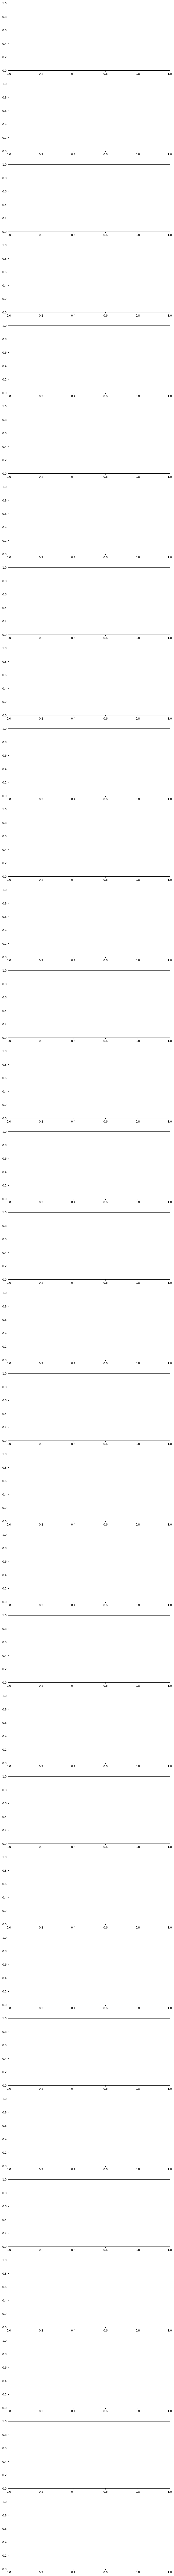

In [21]:
# проверим выполнение кода выше
import matplotlib.pyplot as plt

batch_size = 32
fig, axes = plt.subplots(nrows=batch_size, ncols=1, figsize=(10, batch_size * 5))

dataloader, dataset = get_dataloader(IMAGES, LABELS, batch_size=batch_size)

# Получение одного батча из dataloader
batch_images, batch_boxes = next(iter(dataloader))

for i in range(len(batch_images)):
    image = batch_images[i]
    boxes = batch_boxes[i]

    # Преобразование тензора изображения к формату (каналы, высота, ширина)
    image = image.permute(1, 2, 0)

    # Отображение изображения
    axes[i].imshow(image)

    # Рисование меток боксов
    for box in boxes:
        x, y, w, h = box
        left = x - w/2
        top = y - h/2
        width = w
        height = h
        rect = plt.Rectangle((left, top), width, height, fill=False, edgecolor='red')
        axes[i].add_patch(rect)

    axes[i].axis('off')

# Оставляем пустые подушки, если размер батча меньше batch_size
for i in range(len(batch_images), batch_size):
    axes[i].axis('off')

plt.tight_layout()
plt.show()



### 5. Обучение моделей-детекторов (3 балла)

Необходимо написать цикл обучения на PyTorch самостоятельно -- это основной критерий в этом пункте. Необходимо обучить обе выбранные модели.

> Результатом выполнения пункта явлется код, запуск которого ведет к обучению модели на выбранном датасете. При обучении **обязательно выводить числовые значения лосса на трейне и валидации**, крайне желательно использовать [`TensorBoard`](https://pytorch.org/docs/stable/tensorboard.html) для визуализации. Обязательно также сохранять модель после каждой N-ой эпохи, чтобы потом ее качество можно было проверить и веса были переиспользуемыми.

### 6. Измерение качества работы модели (метрики согласуются с руководителем и зависят от задачи) (2 балла)

Под метриками понимаются функции/формулы, по которым оценивается качество модели-детектора. Обычно для измерения качества работы детектора используют поклассовые Precision, Recall, F1-меру и mean Average Precision (mAP). Подробнее про них можно послушать в [видеолекции 2018 года](https://www.youtube.com/watch?v=ewkSI2cuyoQ&list=PL0Ks75aof3ThkitsZbUOEQg7Ybl5kB_s3&index=24).

**Необходимо самостоятельно реализовать требуемые метрики!**

> Результат пункта --- реализованные функции метрик для задачи детектирования, позволяющие оценить качество работы модели на выборке, а также оценка обеих обученных моделей по данным метрикам на test. Необходимо сделать вывод о том, какая модель сработала лучше и оценить полученный результат.

### 7. Поиск путей применения этой модели в бизнесе/реальных задачах/набросок встраивания в веб/мобильное демо (1 балл)

В этом пункте нужно подумать, как эта модель может быть использована в дальнейшем. То есть, например, зачем нужно детектировать фрукты? Или одежду?

> Результат пункта $-$ перечисленные кейсы использования модели (описанные **как можно подробнее**).

**IMPORTANT NOTE:** Обычно этим вопросом все же задаются до начала какой-либо разработки. Но поскольку проект носит учебный/исследовательский характер, допустимо говорить об этом в конце

# Продуктовый трек

На этом треке вам не понадобится обучать свою модель детекции (хотя никто не запрещает вам это делать), но необходимо, во-первых, продумать **продуктовую составляющую проекта** (проблема людей, которая решается в данном проекте, целевая аудитория продукта, оптимальный способ внедрения модели), а также создать [MVP](https://ru.wikipedia.org/wiki/%D0%9C%D0%B8%D0%BD%D0%B8%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE_%D0%B6%D0%B8%D0%B7%D0%BD%D0%B5%D1%81%D0%BF%D0%BE%D1%81%D0%BE%D0%B1%D0%BD%D1%8B%D0%B9_%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%82) , **внедрив модель детекции в цифровой сервис**, который может быть реализован как Telegram-бот, Web-демо, Desktop-приложение.

Ваша модель не обязательно должна содержать в себе лишь детекцию: например, существуют составные модели, которые осуществляют детекцию лиц на фотографии и определяют их настроение/возраст. Такие модели тоже можно и даже желательно использовать, если того требует проект. Единственное требование --- чтобы детекция присутствовала в качестве основной/вспомогательной задачи.

Если у Вас есть опыт веб- или мобильной разработки, можете работать в рамках привычных Вам инструментов. Главное, чтобы в итоге они позволяил встроить в себя нейросетевой детектор, на вход которому будут поступать картинки.

Изображения на вход демо могут поступать с веб-камеры, из файлов, по ссылке или с камеры мобильного телефона -- способ должен вытекать из предполагаемого сценария применения вашего продукта. Демо должно показывать, что детектор успешно отрабатывает на поданных изображениях и находит нужные объекты.

## План работы

### 1. Поиск проблемы и описание решения (2 балла)
В этом пункте необходимо сформулировать проблему реального мира и продумать, как именно она будет решаться с помощью вашего продукта.

#### Как должен быть устроен ваш продукт
Здесь мы не будем подробно обсуждать, как создавать IT-продукты, которые будут пользоваться широким спросом и способны генерировать выручку. Но кратко опишем!

1. **Ваш продукт должен решать существующую проблему**. Исследования показывают, что это основная причина провала стартапов --- решение не существующей проблемы. О том, как создать стартап, который решает реальную проблему пользователя, можно прочитать [здесь](https://stfalcon.com/ru/blog/post/startups-solving-user-problems). Также есть отличная книжка "Спроси маму", которую необходимо прочитать любому человеку, который создает свой продукт.

2. **Ваш продукт должен иметь целевую аудиторию**. Этот пункт увязан с предыдущим. Если у продукта нет целевой аудитории, его никто не будет использовать.

3. **Ваш продукт должен быть оформлен в сервис, подходящий для основного сценария использования продукта и целевой аудитории**. Предположим, например, что вы делаете цифровой сервис для распознавания языка жестов. Как может выглядеть такой продукт и в какой сервис он может быть внедрён? Например, если создать ТГ-бота, который будет детектировать и распознавать жест по фотографии, его довольно сложно будет использовать, потому что каждый жест в отдельности сфотографировать нельзя. Оптимальным решением в этом случае было бы мобильное приложение с потоковым детектированием жеста на видео и автоматическим добавлением субтитров. При этом именно такой продукт может быть слишком сложен в реализации. Тогда необходимо выбрать оформление сервиса, которое будет осмысленно с продуктовой точки зрения и которое вы при этом сможете реализовать.

#### Как искать проблему
Есть много способов найти важную и актуальную проблему. Некоторые советы перечислены в книге "Спроси маму". Несколько коротких советов можно найти [здесь](https://vc.ru/life/1735-startup-ideas).
* Можно подумать о темах, которые близки лично вам/вашим знакомым. Если проект решает проблему даже узкой целевой аудитории, это не страшно.
* Можно найти уже существующий проект и улучшить его, обозначив, в чем преимущество вашего решения перед конкурентами.
* У человечества вообще много глобальных [проблем](https://www.un.org/sustainabledevelopment/ru/sustainable-development-goals/), над которыми борются различные мировые организации. Если ваш проект способен хоть в каком-то частном случае продвинуться к решению этих проблем, это уже будет отлично.
* Для поиска идей можно использовать датасеты с kaggle.

> Результат пункта -- подробное описание проблемы, которую вы решаете, целевая аудитория использования продукта, а также **подробное** описание сервиса, который предлагается создать. Допускается описать "идеальный продукт", а затем создать MVP, имеющий отклонения от оптимального варианта, сославшись на ограниченное время/ресурсы для выполнения проекта. Но тогда это необходимо отдельно упомянуть в этом пункте.

### 2. Поиск обученной модели и датасета (1 балл)

В этом пункте вам необходимо выбрать модель, которую вы встроите в ваш продукт, и датасет, на котором вы эту модель будете тестировать.

* Если вы найдете готовую модель, которую можно применить для вашей задачи, можно просто взять её. В этом случае с датасетом можно особо не заморачиваться. Достаточно в этом пункте запустить ваш детектор на нескольких (5-7) изображениях, на которых модель будет в итоге применяться, и проверить, что модель на них хорошо работает.


### Бонус. 2.5. Обучение модели для вашей задачи (5 баллов)
**За этот пункт ставятся бонусные баллы. Он не является обязательным.**

Если готовой обученной модели вы не смогли найти, тогда необходимо будет обучить модель самостоятельно. В таком случае перед выполнением пункта 2 вам необходимо будет найти подходящий датасет и обучить любую модель детекции с помощью встроенных методов из фреймворков, описанных в первом сценарии:
- `torchvision.models.detection` и `torchhub`: "нативные" модели для детектирования прямо из PyTorch. Примеры использования есть прямо на занятиях DLSchool по практике CV [2019 года](https://www.youtube.com/watch?v=XSPYe4-y4HE) и [2020 года](https://stepik.org/lesson/458313/step/1?unit=616131);
- `mmdetection`: как с ним работать, рассказывается в [практическом занятии](https://stepik.org/lesson/458313/step/2?unit=616131).
- `detectron2`: краткая информация есть в конце [занятия DLSchool по практике CV](https://www.youtube.com/watch?v=XSPYe4-y4HE), можно начать с него. Лучше самостоятелньо изучить [официальный репозиторий](https://github.com/facebookresearch/detectron2) и уже с ним работать в дальнейшем ("Quick Start");
- `TensorFlow Object Detection API`: как с ним работать рассказывается в [занятии 2018 года](https://www.youtube.com/watch?v=xHIzyrU1uVM). Работать предстоит с [официальным репозиторием](https://github.com/tensorflow/models/tree/master/research/object_detection).

После обучения модель нужно будет протестировать на real-world изображениях, на которых планируется использовать продукт.

### 3. Выбор фреймворка/библиотеки для разработки веб/мобильного демо (0 баллов)

Основным инструментом для разработки веб-демо будет микрофреймворк **Flask**: [серия туториалов на русском](https://habr.com/ru/post/346306/).   
Полезные ресуры:
- [курс по веб-разработке](https://www.youtube.com/playlist?list=PLzQrZe3EemP5KsgWGnmC0QrOzQqjg3Kd5), нас интересуют первые 7 видео в плейлисте. В частности, нужны видео по Flask, там очень хорошие обучалки параллельно с лектором;
- [исчерпывающий справочник по Flask (англ)](https://www3.ntu.edu.sg/home/ehchua/programming/webprogramming/Python3_Flask.html);
- можно посмотреть мой [репозиторий с реализацией веб-демо](https://github.com/izaharkin/Respalyzer) для ML-задачи оценки отзывов.

Для разработки мобильного демо стоит выбрать инстурмент на свое усмотрение:
- под Android: [пример на Pytorch Mobile](https://towardsdatascience.com/object-detector-android-app-using-pytorch-mobile-neural-network-407c419b56cd), [пример на TensorFlow Lite](https://www.tensorflow.org/lite/models/object_detection/overview). **Примечание** от Дмитрия Шумилина: на Android с TF Lite на момент января 2021 есть [ошибка](https://github.com/tensorflow/models/issues/9341) с новым форматом хранения модели. Можно попробовать возможное [решение](https://www.youtube.com/watch?v=syTKGY-H44E&ab_channel=DoomsdayRobotics) или писать на чистом Java. Также можно попробовать использовать более старые версии TensorFlow, в которых проблем совместимости еще не было, например, [v2.1.0](https://github.com/tensorflow/tensorflow/releases/tag/v2.1.0).
- под iOS: [пример на TensorFlow Lite Swift API](https://www.tensorflow.org/lite/guide/inference#load_and_run_a_model_in_swift), [пример с Vision Framework](https://developer.apple.com/documentation/vision/recognizing_objects_in_live_capture) на "чистом" Swift'е.

Разумеется, лучше **самостоятельно поискать видео/статьи** на тему использования моделей на мобильных устройствах.

> Результатом пункта является зафисированный для вас инструмент для разработки демо.

### 4. Разработка демо (3 балла)

Этот пункт про сам процесс написания кода для демо.

> Результатом пункта является код, который можно запустить. Не хватать будет только логики детектора, сам интерфейс должен быть уже рабочим.

### 5. Встраивание модели-детектора в демо (2 балла)

Этот пункт про процесс дописывания кода, который будет обеспечивать "логику" демо $-$ само детектирование.

> Результатом пункта является код, который можно запустить и продемонстрировать работающую систему детектирования объектов.

### 6. Тестирование демо (1 балл)

Здесь нужно запустить ваше демо на как можно большем количестве примеров, чтобы понять, в чем его сильные и слабые стороны. То есть какие объекты/сцены детектор обрабатывает легко, а с какими ему справится сложно. Нужно предложить также пути для улучшения модели на основе увиденных ошибок.

> Результатом пункта является набор изображений, на которых демо отработало. Для каждого изображения нужно добавить комментарии, почему модель справилась хорошо/плохо, предложить пути ее улучшения.

### 7. Улучшение дизайна / Развертывание демо на сервере (1 балл)

В этом пункте можно пойти двумя путями:
1. Проделать работу по улучшению визуальной составляющей демо (интерфейс)
2. Загрузить модель на какой-нибудь сервер/хост/test-flight (в случае мобильного iOS-демо), чтобы к демо можно было обратиться прямо в адресной строке браузера / найти в Telegram

\> По *первому пункту* могу посоветовать использовать библиотеку [Bootstrap](https://habr.com/ru/post/349060/), для мобильного демо элементы UI/UX являются частью основной разработки (поэтому стоит просто погуглить/почитать документацию).

\> *Второй пункт - в случае веб-демо*:

Способ 1: Google Cloud Engine.

Если ваше приложение требует установки системных пакетов, например, через `apt-get install`, то вам придется работать на выделенном сервере VPN или на виртуальной машине. К счастью тот же [Google Cloud](https://cloud.google.com/compute) предоставляет бесплатные 300$ на 90 дней использования Виртуальной машиной, чего хватит в большинстве случаев. Эти ссылки помогут вам понять, как в таком случае создать виртуальную машину, установить и настроить виртуальное окружение и вебсервер, а также задеплоить проект:

- [Deploying a Flask app to a Virtual Machine](https://www.youtube.com/watch?v=a2g9pDleGQk&ab_channel=JulianNash)
- [Set up Gunicorn and Nginx](https://www.digitalocean.com/community/tutorials/how-to-serve-flask-applications-with-gunicorn-and-nginx-on-ubuntu-20-04-ru)

Способ 2: Heroku.

Если с GCE проблемы/не хочется привязывать карту и т.д., могут помочь эти ресурсы и сервис [Heroku](https://www.heroku.com/):
- [Flask deployment](http://www.tutorialspoint.com/flask/flask_deployment.htm)
- [Deploy Flask app to Heroku (youtube)](https://www.youtube.com/watch?v=pmRT8QQLIqk)
- [Deploy Flask app to Heroku (medium)](https://medium.com/the-andela-way/deploying-your-flask-application-to-heroku-c99050bce8f9)
- [Set your own domain name on Heroku](https://devcenter.heroku.com/articles/custom-domains)

\> *Второй пункт - в случае мобильного демо*:

Здесь с как таковым деплоем сложнее, обычно мобильные приложения публикуются или в Google Play (Android), или в AppStore (iOS). Однако можно снять **видеопоказ экрана (скринкаст)** с использованием написанного приложения -- вполне подойдет для публичной демонстрации.

> Результат пункта --- видео с описанием продукта и демонстрацией работы сервиса, который развернут в интернете и доступен для использования. Также необходимо кинуть ссылку на сам сервис, если удалось его развернуть.

<h2 style="text-align: center;"><b>Критерии оценивания</b></h2>

* 1 пункт $-$ 1 балл
* 2 пункт $-$ 1 балл
* 3 пункт $-$ 0 баллов (промежуточный пункт)  
* 4 пункт $-$ 3 балла   
* 5 пункт $-$ 3 балла   
* 6 пункт $-$ 1 балл
* 7 пункт $-$ 1 балл
* Максимум баллов по проекту $-$ 10  

**Успехов в выполнении проекта!**

Желаю всем проделать полезную, интересную и качественную работу, которую потом нестыдно и в резюме указать, и друзьям показать ;)